# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [ ]:
#!pip install -U matplotlib==2.0.2

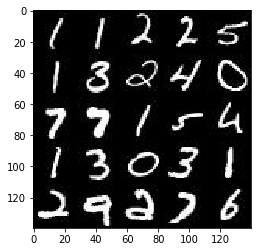

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

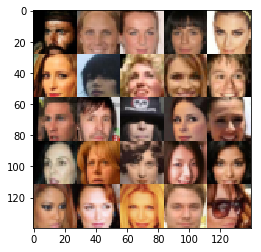

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    inputs_learning_rate = tf.placeholder(tf.float32, name='input_learning_rate')

    return inputs_real, inputs_z, inputs_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same')
        lrelu1 = tf.maximum(alpha*x1,x1)
        
        x2=tf.layers.conv2d(lrelu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        lrelu2 = tf.maximum(alpha*bn2,bn2)
        
        x3 = tf.layers.conv2d(lrelu2,256,5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        lrelu3 = tf.maximum(alpha*bn3,bn3)
        
        #flatten
        flat = tf.reshape(lrelu3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1,x1)        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2,x2)

        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0    
    print_every=10
    show_every=100
    
    #model inputs
    inputs_real, inputs_z, inputs_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #model loss
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    #optimizer
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
            
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, inputs_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, inputs_learning_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

    return               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0319... Generator Loss: 16.5335
Epoch 1/2... Discriminator Loss: 3.1967... Generator Loss: 13.6446
Epoch 1/2... Discriminator Loss: 2.3762... Generator Loss: 2.8184
Epoch 1/2... Discriminator Loss: 1.8167... Generator Loss: 2.3482
Epoch 1/2... Discriminator Loss: 1.8689... Generator Loss: 0.3124
Epoch 1/2... Discriminator Loss: 1.8626... Generator Loss: 0.2744
Epoch 1/2... Discriminator Loss: 1.5942... Generator Loss: 0.5375
Epoch 1/2... Discriminator Loss: 2.1146... Generator Loss: 2.0057
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.4977
Epoch 1/2... Discriminator Loss: 1.7174... Generator Loss: 0.2849


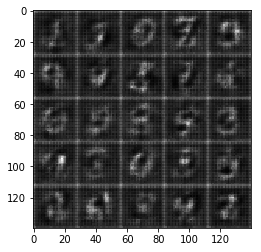

Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 0.3390
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.4005
Epoch 1/2... Discriminator Loss: 1.2499... Generator Loss: 0.7446
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 1.3485
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.3375
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 1.4302
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 1.0363


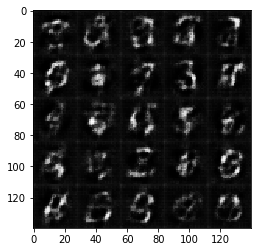

Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 1.6086
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.8300
Epoch 1/2... Discriminator Loss: 1.9474... Generator Loss: 0.1852
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.3165
Epoch 1/2... Discriminator Loss: 1.7509... Generator Loss: 2.5716
Epoch 1/2... Discriminator Loss: 1.6724... Generator Loss: 0.2800
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.4563
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.7131
Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.5406... Generator Loss: 0.3287


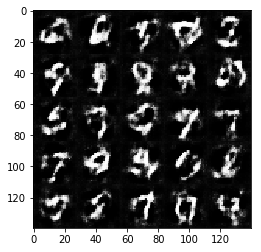

Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.7966... Generator Loss: 0.2165
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 1.4120
Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.4588
Epoch 1/2... Discriminator Loss: 1.5500... Generator Loss: 0.3393
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 0.6253
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 1.2579
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.4553


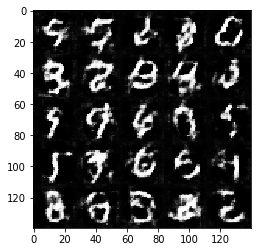

Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 0.5374
Epoch 1/2... Discriminator Loss: 2.2784... Generator Loss: 0.1356
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.3644
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 1.1807
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.4354
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 0.9115
Epoch 1/2... Discriminator Loss: 1.0428... Generator Loss: 0.8946
Epoch 1/2... Discriminator Loss: 1.5995... Generator Loss: 0.2813
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.4817
Epoch 1/2... Discriminator Loss: 1.7262... Generator Loss: 0.2419


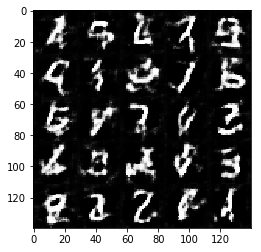

Epoch 1/2... Discriminator Loss: 1.7409... Generator Loss: 0.2782
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 1.7608... Generator Loss: 0.2675
Epoch 1/2... Discriminator Loss: 1.5628... Generator Loss: 0.3022
Epoch 1/2... Discriminator Loss: 1.4449... Generator Loss: 0.3516
Epoch 1/2... Discriminator Loss: 1.5642... Generator Loss: 0.3082
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 1.6278
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 0.2895


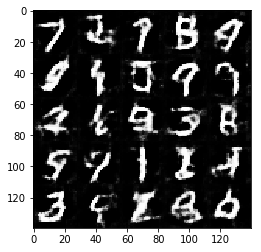

Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.3937
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.5184
Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.4299
Epoch 1/2... Discriminator Loss: 1.9103... Generator Loss: 0.2259
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 1.9619... Generator Loss: 0.1913
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.3774
Epoch 1/2... Discriminator Loss: 1.7588... Generator Loss: 0.2730


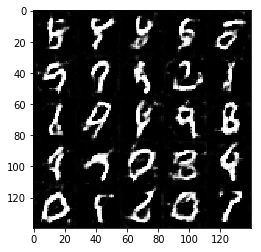

Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.3779
Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 1.1902
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 0.8249
Epoch 1/2... Discriminator Loss: 1.6924... Generator Loss: 0.2695
Epoch 1/2... Discriminator Loss: 1.8582... Generator Loss: 0.2345
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.4975
Epoch 1/2... Discriminator Loss: 1.6056... Generator Loss: 0.2935
Epoch 1/2... Discriminator Loss: 1.8979... Generator Loss: 0.2368
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.4966


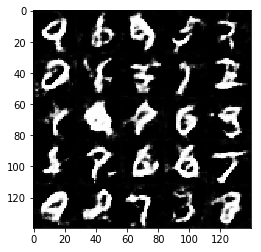

Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.5161
Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 1.2001
Epoch 1/2... Discriminator Loss: 0.6860... Generator Loss: 1.1906
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 1.9687
Epoch 1/2... Discriminator Loss: 1.8071... Generator Loss: 0.2262
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.5181
Epoch 1/2... Discriminator Loss: 2.2144... Generator Loss: 3.6758
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.3158
Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 0.6827


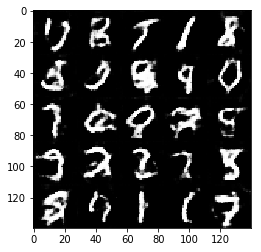

Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.4954
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 1.9082
Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 1.1776
Epoch 1/2... Discriminator Loss: 1.1942... Generator Loss: 0.4995
Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 0.7301
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 3.3604
Epoch 1/2... Discriminator Loss: 0.8144... Generator Loss: 0.7747


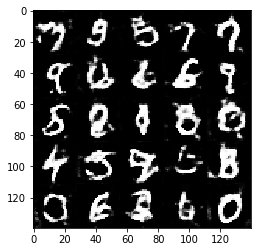

Epoch 1/2... Discriminator Loss: 0.5472... Generator Loss: 1.4841
Epoch 1/2... Discriminator Loss: 0.3122... Generator Loss: 1.8853
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.4651
Epoch 1/2... Discriminator Loss: 1.1931... Generator Loss: 0.4800
Epoch 1/2... Discriminator Loss: 0.6953... Generator Loss: 1.1445
Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.4035
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.5038
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.8557
Epoch 1/2... Discriminator Loss: 1.0413... Generator Loss: 0.7086
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.3838


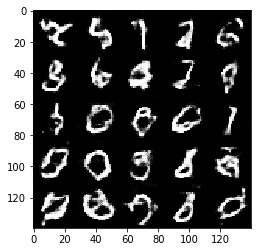

Epoch 1/2... Discriminator Loss: 0.5963... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 0.7689... Generator Loss: 0.9662
Epoch 1/2... Discriminator Loss: 0.7209... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 0.9337... Generator Loss: 0.6794
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 0.5485
Epoch 1/2... Discriminator Loss: 0.7708... Generator Loss: 0.7620
Epoch 1/2... Discriminator Loss: 0.6220... Generator Loss: 1.4513
Epoch 1/2... Discriminator Loss: 1.0370... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.2772
Epoch 1/2... Discriminator Loss: 0.6284... Generator Loss: 2.0934


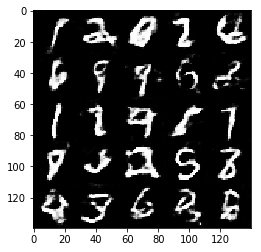

Epoch 1/2... Discriminator Loss: 0.6833... Generator Loss: 1.1327
Epoch 1/2... Discriminator Loss: 2.0919... Generator Loss: 3.7102
Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 1.7274
Epoch 1/2... Discriminator Loss: 0.3999... Generator Loss: 1.7024
Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.1976
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.6789
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.3892
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.9288
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.6562
Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 1.1067


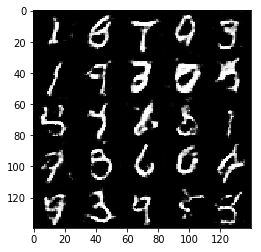

Epoch 1/2... Discriminator Loss: 0.6201... Generator Loss: 1.8859
Epoch 1/2... Discriminator Loss: 0.5134... Generator Loss: 1.3646
Epoch 1/2... Discriminator Loss: 0.9158... Generator Loss: 0.7376
Epoch 1/2... Discriminator Loss: 2.2626... Generator Loss: 3.8793
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.3833
Epoch 1/2... Discriminator Loss: 0.8229... Generator Loss: 0.8484
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.4399
Epoch 1/2... Discriminator Loss: 1.7157... Generator Loss: 0.2995
Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 0.6717... Generator Loss: 0.9139


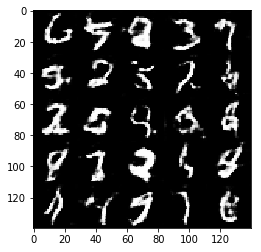

Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.4053
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 1.3670
Epoch 1/2... Discriminator Loss: 0.4915... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 5.0743... Generator Loss: 8.8046
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.5271
Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 1.8629
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 0.4994


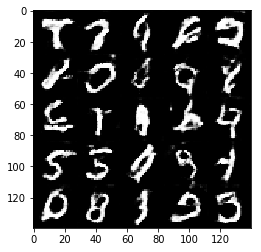

Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 0.4982... Generator Loss: 1.4139
Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 0.9837
Epoch 1/2... Discriminator Loss: 0.7668... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 0.5978... Generator Loss: 1.2850
Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 1.4465
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.5416
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.4458
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 0.5160


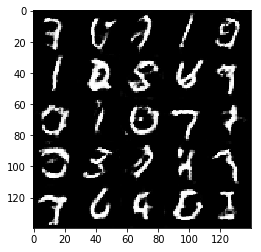

Epoch 1/2... Discriminator Loss: 0.4746... Generator Loss: 1.2024
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 0.5528... Generator Loss: 1.2243
Epoch 1/2... Discriminator Loss: 2.5204... Generator Loss: 0.1744
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 2.8770
Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.5791
Epoch 1/2... Discriminator Loss: 0.6049... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 0.9152
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 0.8030


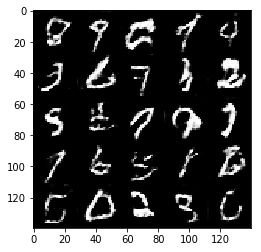

Epoch 1/2... Discriminator Loss: 0.7440... Generator Loss: 2.8551
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 2.2289
Epoch 1/2... Discriminator Loss: 0.6528... Generator Loss: 2.1536
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.3467
Epoch 1/2... Discriminator Loss: 0.4249... Generator Loss: 1.5428
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 0.7114... Generator Loss: 0.8059
Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 0.8891
Epoch 1/2... Discriminator Loss: 0.9191... Generator Loss: 0.8562
Epoch 1/2... Discriminator Loss: 1.0752... Generator Loss: 0.5209


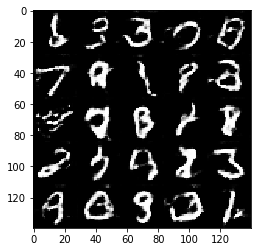

Epoch 1/2... Discriminator Loss: 0.5487... Generator Loss: 1.2308
Epoch 1/2... Discriminator Loss: 0.4605... Generator Loss: 1.3426
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 2.4916
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 0.6599... Generator Loss: 0.9418
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 0.8024
Epoch 2/2... Discriminator Loss: 0.4838... Generator Loss: 1.3201
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 0.4624
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 1.5593


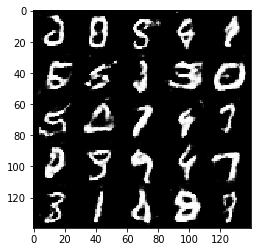

Epoch 2/2... Discriminator Loss: 4.9820... Generator Loss: 8.7176
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 1.1636
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 0.6014
Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 0.4892
Epoch 2/2... Discriminator Loss: 0.4274... Generator Loss: 1.4313
Epoch 2/2... Discriminator Loss: 0.4989... Generator Loss: 1.5869
Epoch 2/2... Discriminator Loss: 1.0319... Generator Loss: 0.6395
Epoch 2/2... Discriminator Loss: 0.6258... Generator Loss: 1.0830
Epoch 2/2... Discriminator Loss: 0.4547... Generator Loss: 1.3297


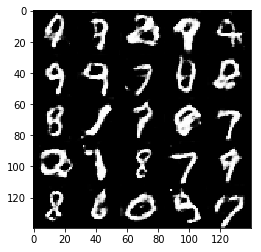

Epoch 2/2... Discriminator Loss: 0.7482... Generator Loss: 0.9097
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 0.8777
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.5825
Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 0.9403
Epoch 2/2... Discriminator Loss: 0.5933... Generator Loss: 1.0956
Epoch 2/2... Discriminator Loss: 0.7069... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 1.6948... Generator Loss: 0.2638
Epoch 2/2... Discriminator Loss: 1.6461... Generator Loss: 0.3254
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 1.0406
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.1058


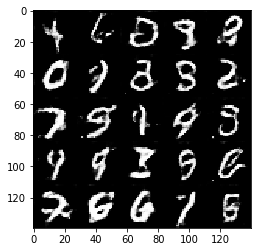

Epoch 2/2... Discriminator Loss: 0.4410... Generator Loss: 1.4549
Epoch 2/2... Discriminator Loss: 0.2916... Generator Loss: 2.2048
Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 1.6437
Epoch 2/2... Discriminator Loss: 0.3338... Generator Loss: 1.6902
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 0.4026... Generator Loss: 1.4468
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 0.6066
Epoch 2/2... Discriminator Loss: 0.5399... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 4.3811


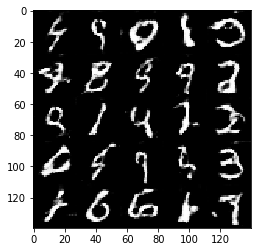

Epoch 2/2... Discriminator Loss: 1.9094... Generator Loss: 4.6832
Epoch 2/2... Discriminator Loss: 0.5485... Generator Loss: 1.2374
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 0.5619
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 0.6819
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 0.4947
Epoch 2/2... Discriminator Loss: 0.6231... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 0.4669... Generator Loss: 1.2121
Epoch 2/2... Discriminator Loss: 0.3087... Generator Loss: 1.6918
Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 2.6349


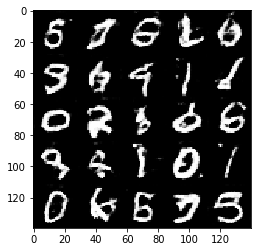

Epoch 2/2... Discriminator Loss: 0.7070... Generator Loss: 0.9340
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 0.4905... Generator Loss: 1.3137
Epoch 2/2... Discriminator Loss: 0.2512... Generator Loss: 2.2260
Epoch 2/2... Discriminator Loss: 1.1520... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 1.8246... Generator Loss: 5.4858
Epoch 2/2... Discriminator Loss: 1.5372... Generator Loss: 0.3492
Epoch 2/2... Discriminator Loss: 0.5922... Generator Loss: 1.1152
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 2.1506


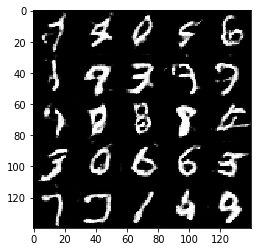

Epoch 2/2... Discriminator Loss: 1.5407... Generator Loss: 0.4344
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 1.3894
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 0.4438... Generator Loss: 1.3912
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.4342
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.0910
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 0.9665


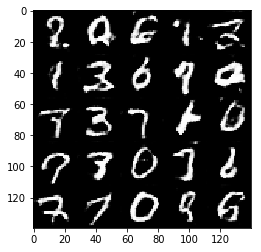

Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 2.0082
Epoch 2/2... Discriminator Loss: 3.1954... Generator Loss: 0.0699
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 0.6104
Epoch 2/2... Discriminator Loss: 0.3572... Generator Loss: 1.6558
Epoch 2/2... Discriminator Loss: 0.4042... Generator Loss: 2.3888
Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 1.2531
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.6411
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 0.8886


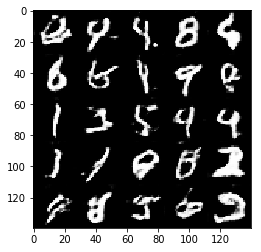

Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 0.6836... Generator Loss: 1.0131
Epoch 2/2... Discriminator Loss: 0.6118... Generator Loss: 1.0638
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 1.4113... Generator Loss: 0.3738
Epoch 2/2... Discriminator Loss: 1.9896... Generator Loss: 0.3568
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 0.9935
Epoch 2/2... Discriminator Loss: 1.7012... Generator Loss: 0.3988
Epoch 2/2... Discriminator Loss: 2.3732... Generator Loss: 0.1459


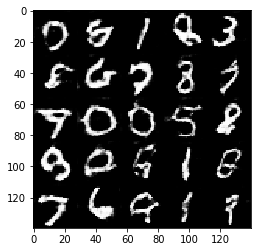

Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 1.0324
Epoch 2/2... Discriminator Loss: 0.5947... Generator Loss: 1.2229
Epoch 2/2... Discriminator Loss: 0.4376... Generator Loss: 1.4523
Epoch 2/2... Discriminator Loss: 0.5268... Generator Loss: 1.1705
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 0.6328
Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 0.5858
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.5669
Epoch 2/2... Discriminator Loss: 0.4661... Generator Loss: 1.9901
Epoch 2/2... Discriminator Loss: 0.4559... Generator Loss: 1.9393
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 0.9287


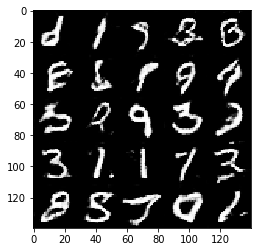

Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 0.5040... Generator Loss: 1.2112
Epoch 2/2... Discriminator Loss: 1.6135... Generator Loss: 0.4050
Epoch 2/2... Discriminator Loss: 0.7976... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 0.9196
Epoch 2/2... Discriminator Loss: 1.5113... Generator Loss: 0.3680
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 0.3941... Generator Loss: 1.6115
Epoch 2/2... Discriminator Loss: 0.4290... Generator Loss: 1.2979
Epoch 2/2... Discriminator Loss: 0.7517... Generator Loss: 0.8838


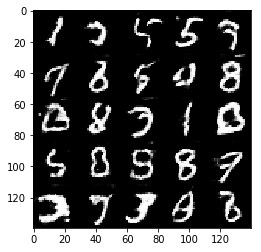

Epoch 2/2... Discriminator Loss: 0.3074... Generator Loss: 1.9471
Epoch 2/2... Discriminator Loss: 0.3660... Generator Loss: 3.3125
Epoch 2/2... Discriminator Loss: 1.7873... Generator Loss: 0.3197
Epoch 2/2... Discriminator Loss: 2.8952... Generator Loss: 0.1252
Epoch 2/2... Discriminator Loss: 0.5677... Generator Loss: 1.3683
Epoch 2/2... Discriminator Loss: 0.8088... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 0.7364
Epoch 2/2... Discriminator Loss: 0.3488... Generator Loss: 1.6148
Epoch 2/2... Discriminator Loss: 5.3602... Generator Loss: 0.0485
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 2.6182


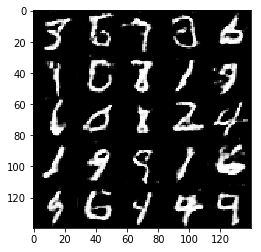

Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 0.5590... Generator Loss: 1.9344
Epoch 2/2... Discriminator Loss: 0.4908... Generator Loss: 1.2873
Epoch 2/2... Discriminator Loss: 0.4368... Generator Loss: 1.4615
Epoch 2/2... Discriminator Loss: 0.4843... Generator Loss: 1.3819
Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 0.5736
Epoch 2/2... Discriminator Loss: 2.9453... Generator Loss: 0.1225
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 4.8994
Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 1.1945
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 0.8052


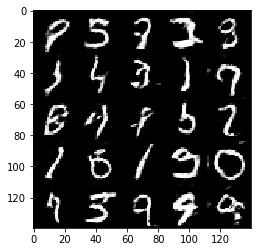

Epoch 2/2... Discriminator Loss: 0.8589... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 0.3493... Generator Loss: 1.4839
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 0.4311... Generator Loss: 1.3529
Epoch 2/2... Discriminator Loss: 0.5813... Generator Loss: 1.1716
Epoch 2/2... Discriminator Loss: 0.4340... Generator Loss: 1.4507
Epoch 2/2... Discriminator Loss: 0.4195... Generator Loss: 1.2968
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 1.3664
Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 0.9521


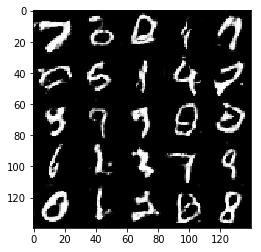

Epoch 2/2... Discriminator Loss: 0.6973... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 2.7704... Generator Loss: 0.1894
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.5723
Epoch 2/2... Discriminator Loss: 2.0648... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 0.9265
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 0.2769... Generator Loss: 1.9015
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 1.6078
Epoch 2/2... Discriminator Loss: 0.8742... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 0.6835... Generator Loss: 0.9395


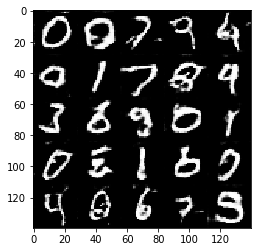

Epoch 2/2... Discriminator Loss: 0.6280... Generator Loss: 1.0697
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 0.2902... Generator Loss: 1.8608
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 0.6676
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.1107
Epoch 2/2... Discriminator Loss: 0.4131... Generator Loss: 1.5211
Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 1.5061
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.0036
Epoch 2/2... Discriminator Loss: 0.3704... Generator Loss: 1.7266


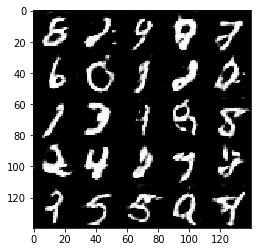

Epoch 2/2... Discriminator Loss: 0.4903... Generator Loss: 1.3138
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.0723
Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.2935
Epoch 2/2... Discriminator Loss: 0.2346... Generator Loss: 2.1852
Epoch 2/2... Discriminator Loss: 0.5534... Generator Loss: 1.2313
Epoch 2/2... Discriminator Loss: 0.4640... Generator Loss: 1.5431
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 0.7846
Epoch 2/2... Discriminator Loss: 0.6115... Generator Loss: 0.9504
Epoch 2/2... Discriminator Loss: 0.2879... Generator Loss: 2.1823


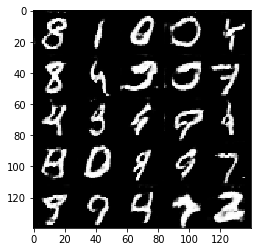

Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.5403
Epoch 2/2... Discriminator Loss: 0.4129... Generator Loss: 1.5945
Epoch 2/2... Discriminator Loss: 0.7896... Generator Loss: 1.0337
Epoch 2/2... Discriminator Loss: 1.1756... Generator Loss: 0.5827
Epoch 2/2... Discriminator Loss: 0.6269... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 0.5236... Generator Loss: 1.2412
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 0.6248
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 1.2864
Epoch 2/2... Discriminator Loss: 13.8355... Generator Loss: 0.0015
Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 1.0689


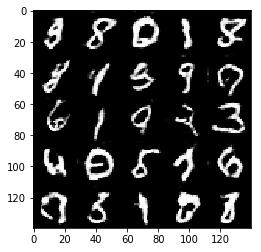

Epoch 2/2... Discriminator Loss: 1.4873... Generator Loss: 0.4828
Epoch 2/2... Discriminator Loss: 1.6663... Generator Loss: 0.3671
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 0.5250... Generator Loss: 1.3861
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 1.1519
Epoch 2/2... Discriminator Loss: 0.5132... Generator Loss: 1.5228
Epoch 2/2... Discriminator Loss: 0.4492... Generator Loss: 1.9063
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 0.5567... Generator Loss: 1.2888


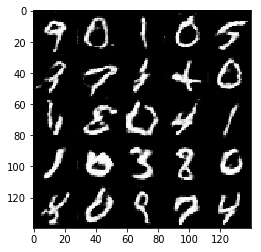

Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 1.0468
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 0.7973
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 0.9170
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 1.3776
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.4796


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 3.8355
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 2.5093... Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 1.9206... Generator Loss: 0.2131
Epoch 1/1... Discriminator Loss: 2.2972... Generator Loss: 0.1543
Epoch 1/1... Discriminator Loss: 2.2722... Generator Loss: 0.1428
Epoch 1/1... Discriminator Loss: 2.2002... Generator Loss: 0.1978
Epoch 1/1... Discriminator Loss: 1.9951... Generator Loss: 0.3007
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.7241... Generator Loss: 0.4034


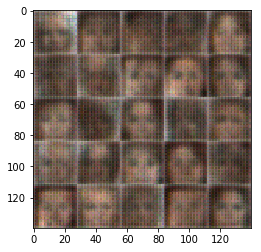

Epoch 1/1... Discriminator Loss: 2.1209... Generator Loss: 0.2395
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.7440
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 1.4937


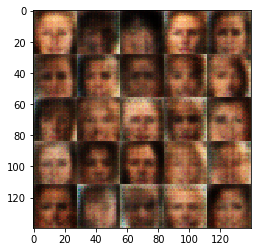

Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.4296
Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.2831
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 2.3519
Epoch 1/1... Discriminator Loss: 1.8992... Generator Loss: 0.2068
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 2.4994... Generator Loss: 0.1068
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 3.8830
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 3.4274


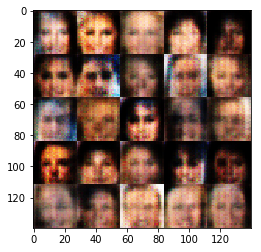

Epoch 1/1... Discriminator Loss: 2.0356... Generator Loss: 0.1744
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 4.3808
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 1.8570
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 0.2761... Generator Loss: 1.7615
Epoch 1/1... Discriminator Loss: 0.2520... Generator Loss: 2.1068
Epoch 1/1... Discriminator Loss: 0.2463... Generator Loss: 1.7727
Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 1.4777
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 1.4902


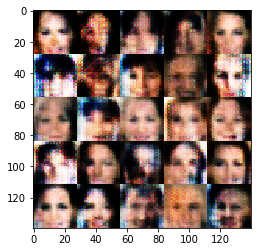

Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 3.9718
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 4.5290
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 5.4149
Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 2.6597
Epoch 1/1... Discriminator Loss: 2.5827... Generator Loss: 6.5212
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 6.4015
Epoch 1/1... Discriminator Loss: 0.5457... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 4.8671
Epoch 1/1... Discriminator Loss: 0.2035... Generator Loss: 2.1026


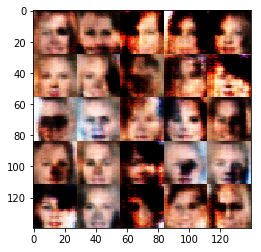

Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 3.6884
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 3.5016
Epoch 1/1... Discriminator Loss: 0.1487... Generator Loss: 4.1880
Epoch 1/1... Discriminator Loss: 0.1255... Generator Loss: 2.8538
Epoch 1/1... Discriminator Loss: 0.1318... Generator Loss: 5.7286
Epoch 1/1... Discriminator Loss: 0.2035... Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 4.5582
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 0.0814... Generator Loss: 3.3123


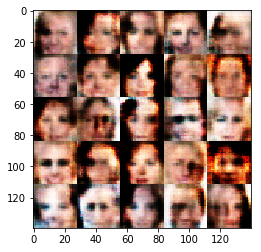

Epoch 1/1... Discriminator Loss: 0.0487... Generator Loss: 5.0283
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 0.0568... Generator Loss: 4.7265
Epoch 1/1... Discriminator Loss: 0.1362... Generator Loss: 2.6121
Epoch 1/1... Discriminator Loss: 0.0279... Generator Loss: 4.8026
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 2.1389
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 0.7299


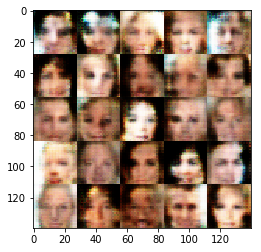

Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.6988
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 1.7648... Generator Loss: 0.2352
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 2.8496... Generator Loss: 3.5253
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 0.8064


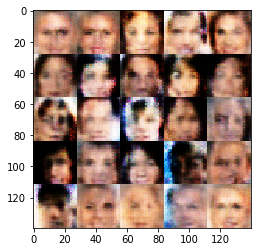

Epoch 1/1... Discriminator Loss: 0.3094... Generator Loss: 4.5664
Epoch 1/1... Discriminator Loss: 0.1137... Generator Loss: 4.9020
Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 5.5103
Epoch 1/1... Discriminator Loss: 0.3038... Generator Loss: 1.7240
Epoch 1/1... Discriminator Loss: 0.1033... Generator Loss: 2.8445
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.5329
Epoch 1/1... Discriminator Loss: 0.1100... Generator Loss: 2.7856
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 1.2227
Epoch 1/1... Discriminator Loss: 0.1962... Generator Loss: 2.0620


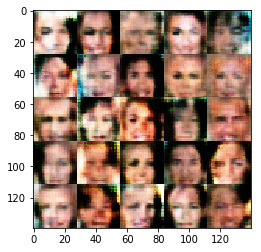

Epoch 1/1... Discriminator Loss: 0.2760... Generator Loss: 1.7147
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 1.4272
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 0.0863... Generator Loss: 4.8353
Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 3.7586
Epoch 1/1... Discriminator Loss: 0.2549... Generator Loss: 2.1364
Epoch 1/1... Discriminator Loss: 0.1723... Generator Loss: 2.2045
Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 4.2156
Epoch 1/1... Discriminator Loss: 0.1950... Generator Loss: 2.0913


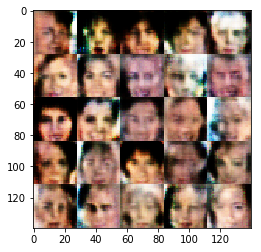

Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 4.9197
Epoch 1/1... Discriminator Loss: 0.0740... Generator Loss: 3.3354
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 6.5887
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 1.4363
Epoch 1/1... Discriminator Loss: 0.1041... Generator Loss: 5.4041
Epoch 1/1... Discriminator Loss: 0.2150... Generator Loss: 6.5379
Epoch 1/1... Discriminator Loss: 0.0508... Generator Loss: 4.0037
Epoch 1/1... Discriminator Loss: 0.0487... Generator Loss: 3.7622
Epoch 1/1... Discriminator Loss: 2.4750... Generator Loss: 0.1403
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.5989


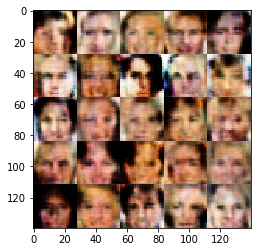

Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 2.9098
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 4.5633
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 3.9803
Epoch 1/1... Discriminator Loss: 0.1828... Generator Loss: 4.6923
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 3.2621
Epoch 1/1... Discriminator Loss: 0.1056... Generator Loss: 2.9877
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 5.7395
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 0.7870


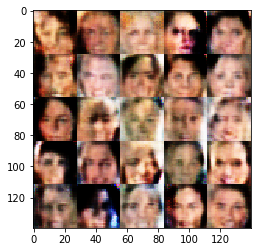

Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 2.4602... Generator Loss: 3.1447
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 1.8852
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 3.9537
Epoch 1/1... Discriminator Loss: 0.2791... Generator Loss: 1.8286
Epoch 1/1... Discriminator Loss: 0.1062... Generator Loss: 2.8448
Epoch 1/1... Discriminator Loss: 0.0726... Generator Loss: 3.0910
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.5951
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 3.0457


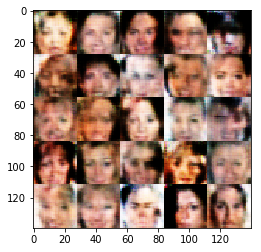

Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 5.6577
Epoch 1/1... Discriminator Loss: 2.0931... Generator Loss: 2.5909
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.5218
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.0935


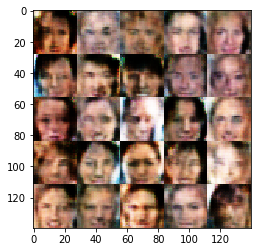

Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.3272
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.5994
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.8655
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.2843
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.7480


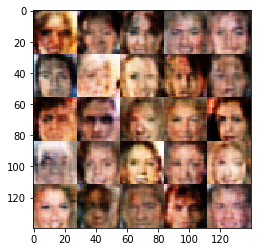

Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 3.0176
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 2.6541
Epoch 1/1... Discriminator Loss: 0.5669... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 4.6841
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 4.2037


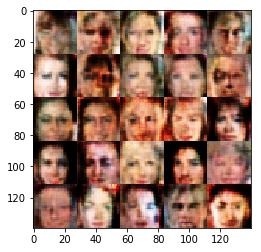

Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 4.5872
Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 0.4915... Generator Loss: 5.8272
Epoch 1/1... Discriminator Loss: 0.0714... Generator Loss: 4.0411
Epoch 1/1... Discriminator Loss: 0.1001... Generator Loss: 3.0305
Epoch 1/1... Discriminator Loss: 0.1975... Generator Loss: 2.1323
Epoch 1/1... Discriminator Loss: 0.0415... Generator Loss: 7.8340
Epoch 1/1... Discriminator Loss: 0.0289... Generator Loss: 4.3684
Epoch 1/1... Discriminator Loss: 0.0293... Generator Loss: 5.4956
Epoch 1/1... Discriminator Loss: 2.4624... Generator Loss: 0.1530


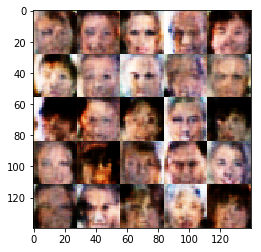

Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 3.1956
Epoch 1/1... Discriminator Loss: 0.2295... Generator Loss: 2.8384
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 2.1992
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 6.1115
Epoch 1/1... Discriminator Loss: 0.0733... Generator Loss: 3.2293
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.5606
Epoch 1/1... Discriminator Loss: 0.0843... Generator Loss: 3.5078


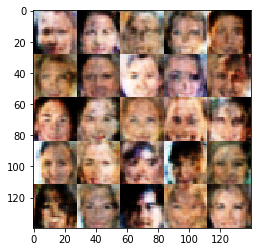

Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 5.7928
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 4.1641
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 1.6296
Epoch 1/1... Discriminator Loss: 0.2139... Generator Loss: 4.9270
Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 5.7481
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 4.1589
Epoch 1/1... Discriminator Loss: 0.2381... Generator Loss: 1.9389
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 0.8812


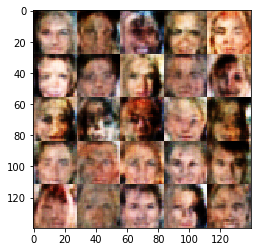

Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 2.1271
Epoch 1/1... Discriminator Loss: 0.2304... Generator Loss: 2.0164
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 4.5485
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 1.4926
Epoch 1/1... Discriminator Loss: 0.0614... Generator Loss: 5.0458
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 0.1957... Generator Loss: 2.0986
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 5.0052


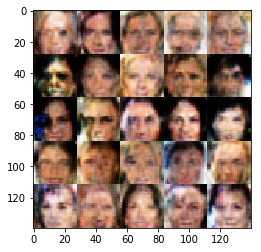

Epoch 1/1... Discriminator Loss: 3.7180... Generator Loss: 3.8299
Epoch 1/1... Discriminator Loss: 0.0848... Generator Loss: 3.7316
Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 5.6854
Epoch 1/1... Discriminator Loss: 0.0652... Generator Loss: 3.7641
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 6.6661
Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 4.7076
Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 5.4173
Epoch 1/1... Discriminator Loss: 0.0183... Generator Loss: 5.5926
Epoch 1/1... Discriminator Loss: 0.0466... Generator Loss: 4.0750
Epoch 1/1... Discriminator Loss: 0.0206... Generator Loss: 6.4518


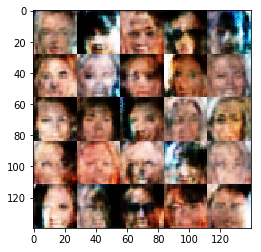

Epoch 1/1... Discriminator Loss: 0.2774... Generator Loss: 1.6832
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 5.0776
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 0.0473... Generator Loss: 4.4657
Epoch 1/1... Discriminator Loss: 0.0568... Generator Loss: 6.1166
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 0.6504... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.3619
Epoch 1/1... Discriminator Loss: 0.0870... Generator Loss: 3.3215


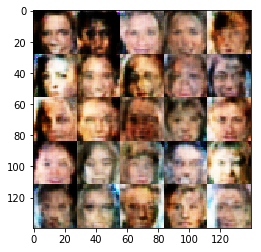

Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 1.3986
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 5.0846
Epoch 1/1... Discriminator Loss: 0.1301... Generator Loss: 2.8526
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.4053
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 4.8100
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 1.4036


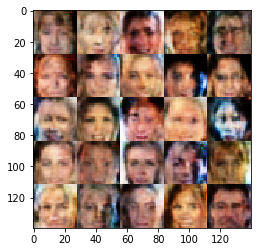

Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 2.2512
Epoch 1/1... Discriminator Loss: 0.2694... Generator Loss: 1.8118
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 5.4980
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 3.7885
Epoch 1/1... Discriminator Loss: 0.3135... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 0.0334... Generator Loss: 5.2588
Epoch 1/1... Discriminator Loss: 0.0224... Generator Loss: 4.9148
Epoch 1/1... Discriminator Loss: 0.0401... Generator Loss: 5.1248
Epoch 1/1... Discriminator Loss: 0.0748... Generator Loss: 3.1760


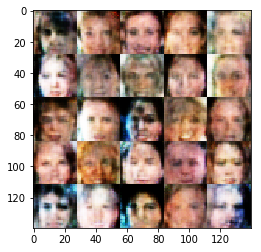

Epoch 1/1... Discriminator Loss: 0.0415... Generator Loss: 4.1620
Epoch 1/1... Discriminator Loss: 3.3702... Generator Loss: 0.0522
Epoch 1/1... Discriminator Loss: 0.0619... Generator Loss: 4.4262
Epoch 1/1... Discriminator Loss: 0.0443... Generator Loss: 3.7608
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 2.9250
Epoch 1/1... Discriminator Loss: 0.0493... Generator Loss: 4.1521
Epoch 1/1... Discriminator Loss: 0.0462... Generator Loss: 4.5369
Epoch 1/1... Discriminator Loss: 0.0410... Generator Loss: 4.4259
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 0.0868... Generator Loss: 3.0764


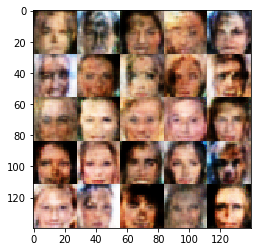

Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 0.2346... Generator Loss: 2.3416
Epoch 1/1... Discriminator Loss: 1.8797... Generator Loss: 0.2150
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 5.7097
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.3211
Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 3.8956
Epoch 1/1... Discriminator Loss: 0.2386... Generator Loss: 2.6751
Epoch 1/1... Discriminator Loss: 0.1356... Generator Loss: 2.7818
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 5.0059
Epoch 1/1... Discriminator Loss: 0.0927... Generator Loss: 3.9816


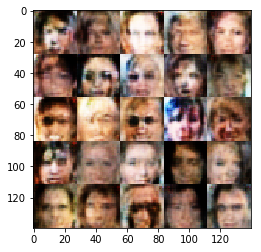

Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 5.6734
Epoch 1/1... Discriminator Loss: 0.2889... Generator Loss: 2.6660
Epoch 1/1... Discriminator Loss: 0.2667... Generator Loss: 1.7729
Epoch 1/1... Discriminator Loss: 5.7217... Generator Loss: 6.1053
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 4.6352
Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 3.1575


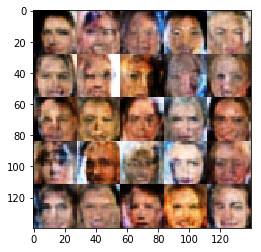

Epoch 1/1... Discriminator Loss: 0.0725... Generator Loss: 4.3398
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 0.1167... Generator Loss: 3.2090
Epoch 1/1... Discriminator Loss: 0.1197... Generator Loss: 2.7095
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 4.4762
Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 4.1747
Epoch 1/1... Discriminator Loss: 0.0959... Generator Loss: 2.7082
Epoch 1/1... Discriminator Loss: 0.3185... Generator Loss: 1.9797
Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 5.7310


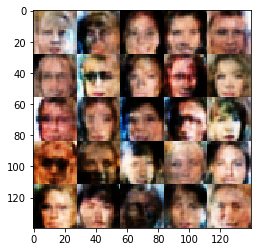

Epoch 1/1... Discriminator Loss: 0.0757... Generator Loss: 3.1931
Epoch 1/1... Discriminator Loss: 0.1541... Generator Loss: 2.3314
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 3.5245
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 3.3595
Epoch 1/1... Discriminator Loss: 0.0334... Generator Loss: 4.9782
Epoch 1/1... Discriminator Loss: 0.2395... Generator Loss: 1.9922
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.1969
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 3.9891
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 4.7784


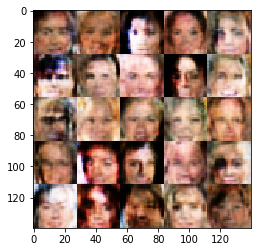

Epoch 1/1... Discriminator Loss: 0.0572... Generator Loss: 4.1657
Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 3.6909
Epoch 1/1... Discriminator Loss: 3.9933... Generator Loss: 0.0242
Epoch 1/1... Discriminator Loss: 0.0729... Generator Loss: 5.2494
Epoch 1/1... Discriminator Loss: 0.0439... Generator Loss: 4.5530
Epoch 1/1... Discriminator Loss: 0.2084... Generator Loss: 2.1741
Epoch 1/1... Discriminator Loss: 0.1621... Generator Loss: 2.7434
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 1.9363... Generator Loss: 0.2286
Epoch 1/1... Discriminator Loss: 0.1444... Generator Loss: 2.6441


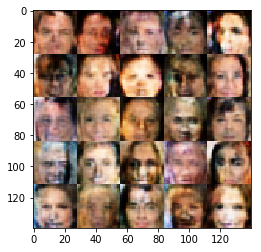

Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 5.1948
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 4.1472
Epoch 1/1... Discriminator Loss: 4.7874... Generator Loss: 0.0111
Epoch 1/1... Discriminator Loss: 0.1292... Generator Loss: 5.3440
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 4.2520
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 4.0567
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.4001
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 3.2985


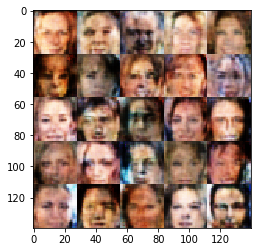

Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.3552
Epoch 1/1... Discriminator Loss: 0.0557... Generator Loss: 3.8773
Epoch 1/1... Discriminator Loss: 0.1194... Generator Loss: 2.7182
Epoch 1/1... Discriminator Loss: 0.0839... Generator Loss: 5.1894
Epoch 1/1... Discriminator Loss: 0.0470... Generator Loss: 4.1551
Epoch 1/1... Discriminator Loss: 3.0910... Generator Loss: 4.5855
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 0.0999... Generator Loss: 2.8634
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.3412
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.6965


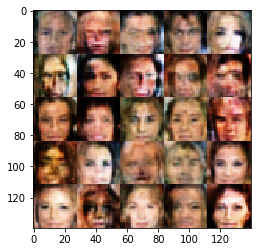

Epoch 1/1... Discriminator Loss: 0.2733... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 3.4399
Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 3.0965
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 7.1862
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 4.7835
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 0.1509... Generator Loss: 6.2529
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.1075


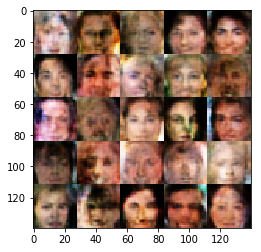

Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 3.3964
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 0.2803... Generator Loss: 1.9861
Epoch 1/1... Discriminator Loss: 0.3274... Generator Loss: 1.5297
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.1516
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 4.1528
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 5.7325
Epoch 1/1... Discriminator Loss: 2.0367... Generator Loss: 4.2163
Epoch 1/1... Discriminator Loss: 0.0706... Generator Loss: 3.9135


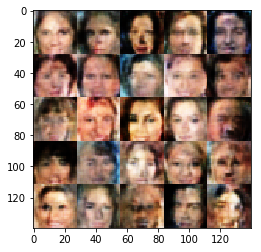

Epoch 1/1... Discriminator Loss: 0.0486... Generator Loss: 4.6695
Epoch 1/1... Discriminator Loss: 0.0937... Generator Loss: 3.0737
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 3.6225
Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 4.8744
Epoch 1/1... Discriminator Loss: 0.1681... Generator Loss: 2.1764
Epoch 1/1... Discriminator Loss: 0.0599... Generator Loss: 4.1153
Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 5.7710
Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 3.1661
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 4.9164
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 5.5899


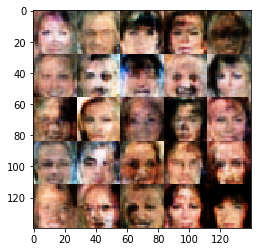

Epoch 1/1... Discriminator Loss: 0.0253... Generator Loss: 5.9903
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 5.7063
Epoch 1/1... Discriminator Loss: 1.9607... Generator Loss: 3.0745
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 2.0786... Generator Loss: 0.1946
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 4.6807
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 1.7510
Epoch 1/1... Discriminator Loss: 0.0946... Generator Loss: 5.9840
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 3.9853
Epoch 1/1... Discriminator Loss: 0.3164... Generator Loss: 3.7836


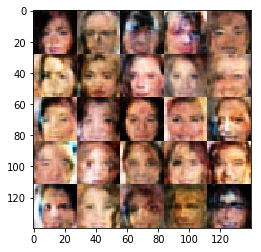

Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.9823... Generator Loss: 4.9174
Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 3.7257
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 1.9669
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 0.1263... Generator Loss: 2.4985
Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 1.5028
Epoch 1/1... Discriminator Loss: 0.6054... Generator Loss: 1.3670


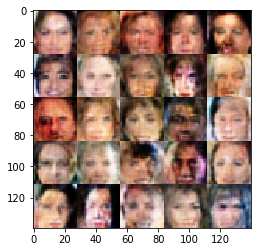

Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 2.0239
Epoch 1/1... Discriminator Loss: 0.1129... Generator Loss: 2.9147
Epoch 1/1... Discriminator Loss: 0.2512... Generator Loss: 1.8150
Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 0.2516
Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 1.4315
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.0546... Generator Loss: 5.2254
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.3552
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 2.8427


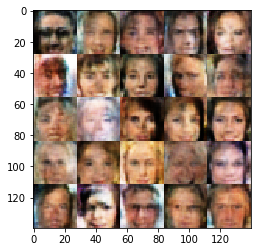

Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 2.8006
Epoch 1/1... Discriminator Loss: 0.2565... Generator Loss: 4.9077
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 2.4513... Generator Loss: 0.1299
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 0.2473... Generator Loss: 3.8179
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 0.1882... Generator Loss: 2.3546
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 4.0219


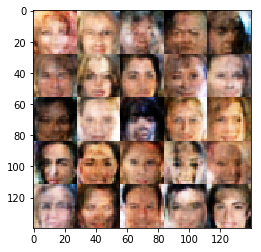

Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 2.4052
Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 1.3504
Epoch 1/1... Discriminator Loss: 0.1084... Generator Loss: 2.7469
Epoch 1/1... Discriminator Loss: 0.2535... Generator Loss: 4.7467
Epoch 1/1... Discriminator Loss: 0.1031... Generator Loss: 5.4039
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 4.9680
Epoch 1/1... Discriminator Loss: 2.7577... Generator Loss: 0.0966
Epoch 1/1... Discriminator Loss: 0.1916... Generator Loss: 2.2233


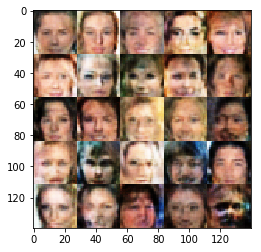

Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 3.6561
Epoch 1/1... Discriminator Loss: 0.0894... Generator Loss: 3.2359
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 0.1148... Generator Loss: 3.4387
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 4.1134
Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 5.2747
Epoch 1/1... Discriminator Loss: 0.0567... Generator Loss: 4.2644
Epoch 1/1... Discriminator Loss: 0.2961... Generator Loss: 1.8373
Epoch 1/1... Discriminator Loss: 0.0763... Generator Loss: 5.4634
Epoch 1/1... Discriminator Loss: 0.0565... Generator Loss: 4.4439


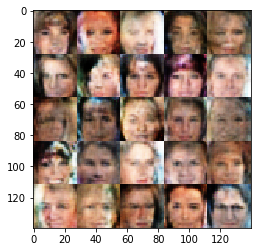

Epoch 1/1... Discriminator Loss: 0.0358... Generator Loss: 4.8583
Epoch 1/1... Discriminator Loss: 0.0405... Generator Loss: 4.3189
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 3.0109
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 3.4663
Epoch 1/1... Discriminator Loss: 0.1199... Generator Loss: 2.9737
Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 4.3914
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 2.8222
Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 3.6946
Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 3.7799
Epoch 1/1... Discriminator Loss: 1.8802... Generator Loss: 4.9706


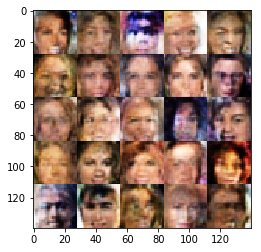

Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.9544... Generator Loss: 0.2377
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.3570
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 0.2054... Generator Loss: 2.7206
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 2.2396
Epoch 1/1... Discriminator Loss: 0.1045... Generator Loss: 2.7177
Epoch 1/1... Discriminator Loss: 0.1075... Generator Loss: 3.8206
Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 3.0115
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 0.9369


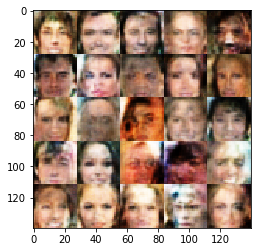

Epoch 1/1... Discriminator Loss: 0.2134... Generator Loss: 6.1896
Epoch 1/1... Discriminator Loss: 0.0713... Generator Loss: 4.2866
Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 5.3583
Epoch 1/1... Discriminator Loss: 0.0224... Generator Loss: 5.6804
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 3.2223
Epoch 1/1... Discriminator Loss: 0.1447... Generator Loss: 4.2652
Epoch 1/1... Discriminator Loss: 0.1382... Generator Loss: 3.7294
Epoch 1/1... Discriminator Loss: 0.1429... Generator Loss: 6.1544
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 5.2926
Epoch 1/1... Discriminator Loss: 0.1045... Generator Loss: 3.0960


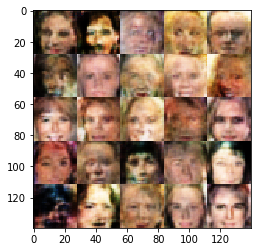

Epoch 1/1... Discriminator Loss: 0.3306... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 0.1418... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 4.5907
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 4.5632
Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 2.2067
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 4.6917
Epoch 1/1... Discriminator Loss: 0.2156... Generator Loss: 4.9821
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 0.9681


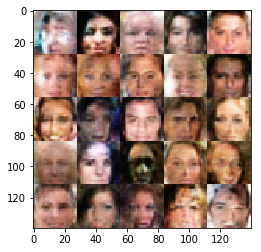

Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 0.3022... Generator Loss: 3.9015
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 0.0350... Generator Loss: 4.2294
Epoch 1/1... Discriminator Loss: 0.1235... Generator Loss: 2.6726
Epoch 1/1... Discriminator Loss: 0.2885... Generator Loss: 2.4222
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 0.0907... Generator Loss: 4.1077
Epoch 1/1... Discriminator Loss: 0.0289... Generator Loss: 6.0443
Epoch 1/1... Discriminator Loss: 0.1236... Generator Loss: 2.6987


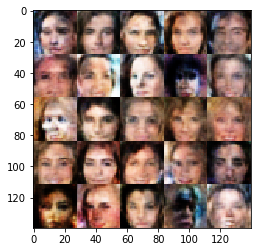

Epoch 1/1... Discriminator Loss: 0.0460... Generator Loss: 5.7832
Epoch 1/1... Discriminator Loss: 0.3208... Generator Loss: 6.1674
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 3.4201
Epoch 1/1... Discriminator Loss: 0.2823... Generator Loss: 1.9536
Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 3.3651
Epoch 1/1... Discriminator Loss: 0.0920... Generator Loss: 6.1755
Epoch 1/1... Discriminator Loss: 0.1771... Generator Loss: 2.5849
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 3.7684
Epoch 1/1... Discriminator Loss: 2.3292... Generator Loss: 2.6835
Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 2.7587


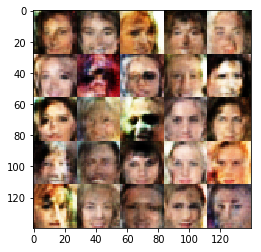

Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 4.4235
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 4.3024
Epoch 1/1... Discriminator Loss: 0.1354... Generator Loss: 2.7677
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 2.6997
Epoch 1/1... Discriminator Loss: 0.1537... Generator Loss: 3.7205
Epoch 1/1... Discriminator Loss: 0.1313... Generator Loss: 3.5148
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 5.6568
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 0.1535... Generator Loss: 2.6626


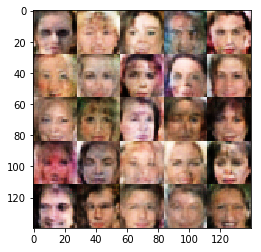

Epoch 1/1... Discriminator Loss: 1.9858... Generator Loss: 0.2926
Epoch 1/1... Discriminator Loss: 0.2440... Generator Loss: 2.2058
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 2.1259
Epoch 1/1... Discriminator Loss: 0.1495... Generator Loss: 2.9630
Epoch 1/1... Discriminator Loss: 2.5143... Generator Loss: 5.7826
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 5.9901
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 4.6211
Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 4.3681


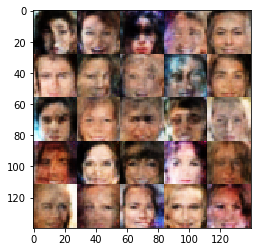

Epoch 1/1... Discriminator Loss: 0.2209... Generator Loss: 2.1110
Epoch 1/1... Discriminator Loss: 0.0428... Generator Loss: 4.2669
Epoch 1/1... Discriminator Loss: 0.0359... Generator Loss: 5.2171
Epoch 1/1... Discriminator Loss: 2.6058... Generator Loss: 0.1404
Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 5.4412
Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 5.4169
Epoch 1/1... Discriminator Loss: 0.0587... Generator Loss: 4.8003
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 1.9942
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.6170
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.2963


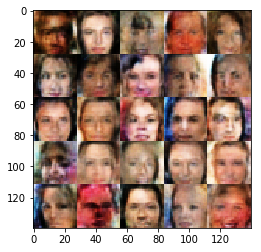

Epoch 1/1... Discriminator Loss: 0.2859... Generator Loss: 2.7008
Epoch 1/1... Discriminator Loss: 0.1713... Generator Loss: 2.3605
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 0.1207... Generator Loss: 2.9667
Epoch 1/1... Discriminator Loss: 0.1406... Generator Loss: 2.6221
Epoch 1/1... Discriminator Loss: 0.0906... Generator Loss: 5.2719
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 5.6765
Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 3.5651
Epoch 1/1... Discriminator Loss: 0.0970... Generator Loss: 6.2181


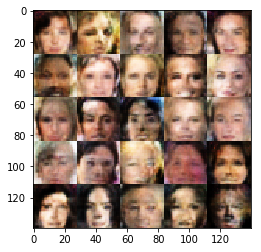

Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 2.0101
Epoch 1/1... Discriminator Loss: 2.2056... Generator Loss: 0.2237
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 1.8990
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 3.2890
Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 2.5529
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 0.0761... Generator Loss: 4.5863
Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 5.2365
Epoch 1/1... Discriminator Loss: 0.0387... Generator Loss: 5.9892
Epoch 1/1... Discriminator Loss: 0.0468... Generator Loss: 3.8061


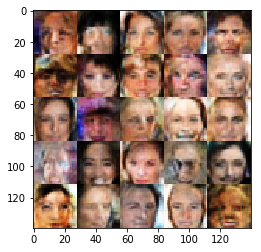

Epoch 1/1... Discriminator Loss: 1.9004... Generator Loss: 4.8096
Epoch 1/1... Discriminator Loss: 0.2240... Generator Loss: 3.8047
Epoch 1/1... Discriminator Loss: 0.2056... Generator Loss: 2.2423
Epoch 1/1... Discriminator Loss: 1.7778... Generator Loss: 0.2277
Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 3.3763
Epoch 1/1... Discriminator Loss: 0.0883... Generator Loss: 3.1253
Epoch 1/1... Discriminator Loss: 2.3253... Generator Loss: 4.4107
Epoch 1/1... Discriminator Loss: 0.5922... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 1.3511


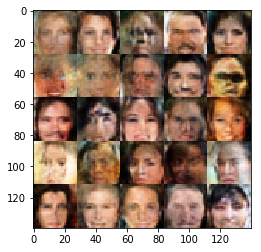

Epoch 1/1... Discriminator Loss: 0.2735... Generator Loss: 2.0021
Epoch 1/1... Discriminator Loss: 0.1263... Generator Loss: 5.2208
Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 1.9659
Epoch 1/1... Discriminator Loss: 0.0369... Generator Loss: 4.2054
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 5.4363
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 4.0308
Epoch 1/1... Discriminator Loss: 0.1206... Generator Loss: 6.2356
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 2.0668
Epoch 1/1... Discriminator Loss: 0.0635... Generator Loss: 4.7346
Epoch 1/1... Discriminator Loss: 0.0376... Generator Loss: 4.5777


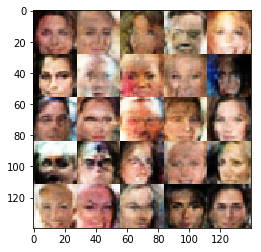

Epoch 1/1... Discriminator Loss: 0.0625... Generator Loss: 3.4269
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 2.9322
Epoch 1/1... Discriminator Loss: 0.0225... Generator Loss: 5.6310
Epoch 1/1... Discriminator Loss: 3.0568... Generator Loss: 6.7752
Epoch 1/1... Discriminator Loss: 0.2386... Generator Loss: 2.0236
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 3.9478
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.4801
Epoch 1/1... Discriminator Loss: 0.1350... Generator Loss: 3.2860
Epoch 1/1... Discriminator Loss: 0.0989... Generator Loss: 4.2073
Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 5.3917


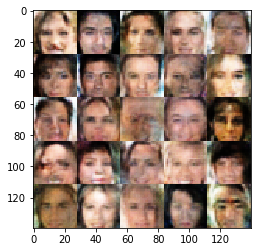

Epoch 1/1... Discriminator Loss: 5.5819... Generator Loss: 7.1953
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 5.2669
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 2.8067
Epoch 1/1... Discriminator Loss: 0.0514... Generator Loss: 4.3515
Epoch 1/1... Discriminator Loss: 0.0500... Generator Loss: 6.3542
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.2628
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 2.0832
Epoch 1/1... Discriminator Loss: 0.2011... Generator Loss: 2.2868


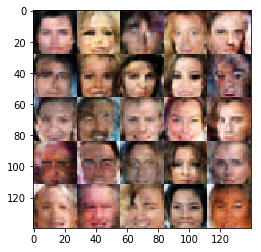

Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 4.9080
Epoch 1/1... Discriminator Loss: 2.8052... Generator Loss: 5.7122
Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 4.1134
Epoch 1/1... Discriminator Loss: 0.0771... Generator Loss: 3.5395
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 2.1838
Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 2.7749
Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 1.6800
Epoch 1/1... Discriminator Loss: 0.1013... Generator Loss: 6.3236
Epoch 1/1... Discriminator Loss: 0.0315... Generator Loss: 5.0888
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 4.0466


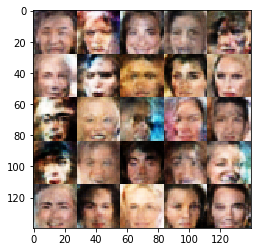

Epoch 1/1... Discriminator Loss: 0.2528... Generator Loss: 2.0979
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 4.0468
Epoch 1/1... Discriminator Loss: 0.1464... Generator Loss: 2.3581
Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 5.0560
Epoch 1/1... Discriminator Loss: 1.7393... Generator Loss: 0.3394
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 3.4721
Epoch 1/1... Discriminator Loss: 0.0950... Generator Loss: 2.9949
Epoch 1/1... Discriminator Loss: 1.9362... Generator Loss: 5.8380
Epoch 1/1... Discriminator Loss: 0.3210... Generator Loss: 1.9593
Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 3.4880


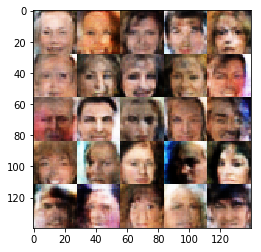

Epoch 1/1... Discriminator Loss: 0.2183... Generator Loss: 1.9015
Epoch 1/1... Discriminator Loss: 0.1506... Generator Loss: 5.6155
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 4.5633
Epoch 1/1... Discriminator Loss: 1.8121... Generator Loss: 0.2689
Epoch 1/1... Discriminator Loss: 1.9650... Generator Loss: 5.6605
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.9074
Epoch 1/1... Discriminator Loss: 0.0375... Generator Loss: 5.1039
Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 3.7371
Epoch 1/1... Discriminator Loss: 0.2476... Generator Loss: 2.0435
Epoch 1/1... Discriminator Loss: 0.1595... Generator Loss: 2.8077


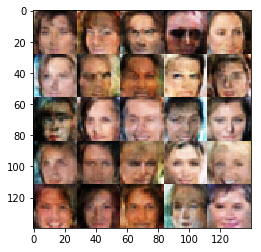

Epoch 1/1... Discriminator Loss: 0.1589... Generator Loss: 5.7100
Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 4.5566
Epoch 1/1... Discriminator Loss: 0.1291... Generator Loss: 2.5789
Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 6.9237
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 5.0423
Epoch 1/1... Discriminator Loss: 0.0639... Generator Loss: 3.4965
Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 0.2958... Generator Loss: 4.2939
Epoch 1/1... Discriminator Loss: 0.0702... Generator Loss: 4.2085
Epoch 1/1... Discriminator Loss: 0.1454... Generator Loss: 2.5496


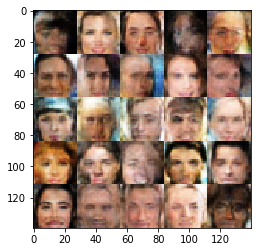

Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 3.8496
Epoch 1/1... Discriminator Loss: 0.0573... Generator Loss: 5.0144
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 1.2214
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 1.3270
Epoch 1/1... Discriminator Loss: 0.0946... Generator Loss: 3.6045
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 3.6866
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 3.5323
Epoch 1/1... Discriminator Loss: 0.1598... Generator Loss: 2.4713
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 6.8021
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 4.1640


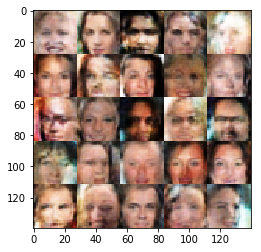

Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 1.9334
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 1.6906
Epoch 1/1... Discriminator Loss: 2.9596... Generator Loss: 0.1202
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 2.1130
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 3.1447
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 3.4849
Epoch 1/1... Discriminator Loss: 0.0381... Generator Loss: 4.7822
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 4.2032


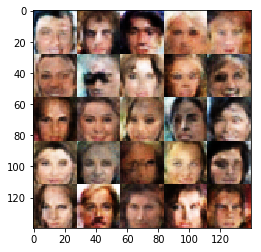

Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 4.0092
Epoch 1/1... Discriminator Loss: 0.0346... Generator Loss: 4.6628
Epoch 1/1... Discriminator Loss: 0.0160... Generator Loss: 6.1982
Epoch 1/1... Discriminator Loss: 1.7232... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 0.2476... Generator Loss: 2.0166
Epoch 1/1... Discriminator Loss: 0.0464... Generator Loss: 5.5186
Epoch 1/1... Discriminator Loss: 0.0376... Generator Loss: 4.7125
Epoch 1/1... Discriminator Loss: 0.0565... Generator Loss: 3.5340
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 4.8423
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 4.7179


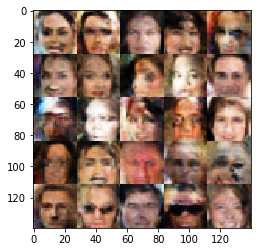

Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 3.8111
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 0.8832


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.